In [1]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import math
import numpy as np
from PIL import Image

In [2]:
##############
# step 1: mosaicing
##############

# read images
img_in = Image.open('data/porto1.png').convert('RGB')
img_ref = Image.open('data/porto2.png').convert('RGB')

# shape of igs_in, igs_ref: [y, x, 3]
igs_in = np.array(img_in)
igs_ref = np.array(img_ref)

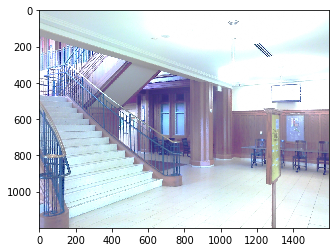

In [3]:
igs_in_img = Image.fromarray(igs_in.astype(np.uint8))
imshow(igs_in_img)

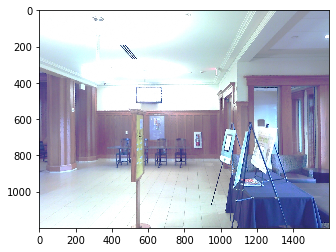

In [4]:
igs_ref_img = Image.fromarray(igs_ref.astype(np.uint8))
imshow(igs_ref_img)

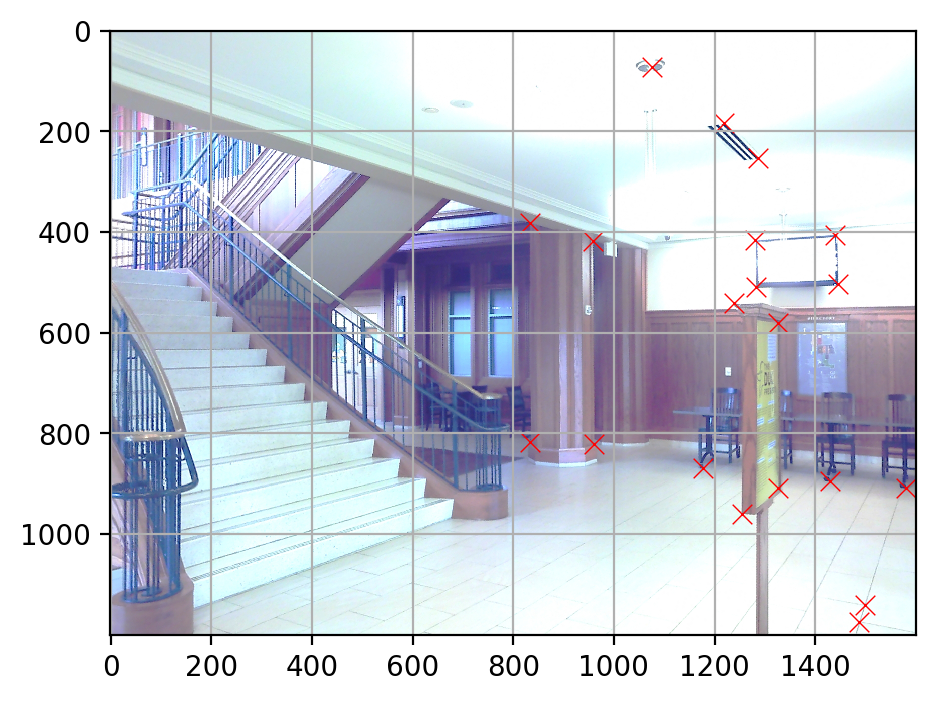

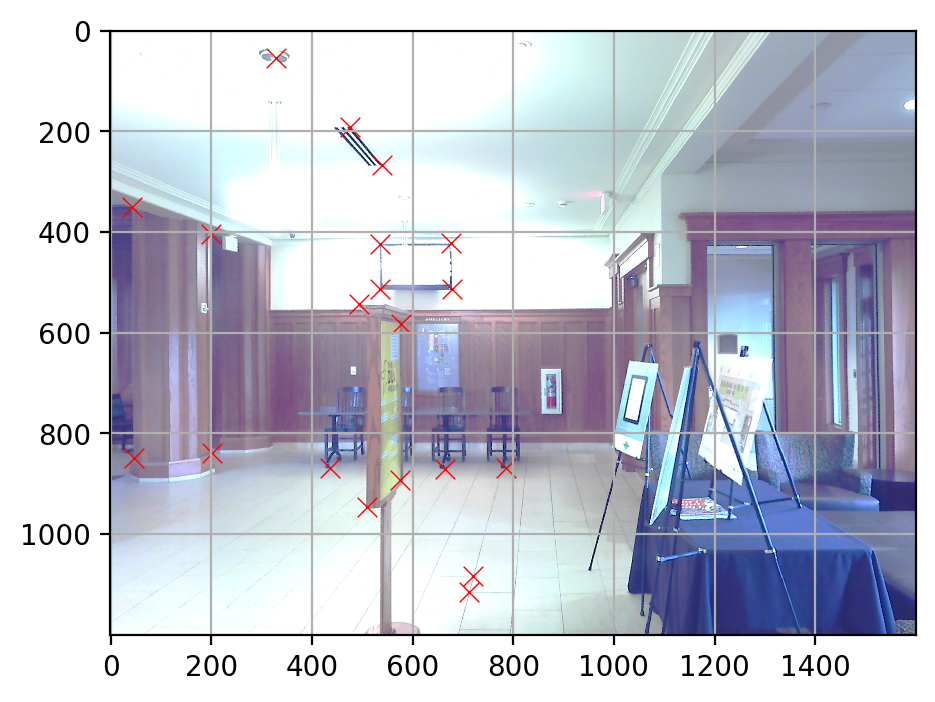

((20, 2), (20, 2))

In [5]:
def set_cor_mosaic():
    # pixel_x and pixel_y
    
    p_in = np.array([[958, 417],
                    [961, 821],
                    [1239, 541],
                    [1254, 959],
                    [1327, 909],
                    [1326, 580],
                    [1445, 504],
                    [1440, 405],
                    [1281, 416],
                    [1283, 509],
                    [1178, 869],
                    [1429, 895],
                    [1581, 908],
                    [1498, 1140],
                    [1487, 1174],
                    [833, 382],
                    [834, 817],
                    [1219, 183],
                    [1287, 253],
                    [1075, 72]])
    
    p_ref = np.array([[199, 403],
                    [202, 839],
                    [493, 542],
                    [509, 947],
                    [576, 893],
                    [577, 583],
                    [679, 513],
                    [677, 422],
                    [535, 424],
                    [536, 513],
                    [435, 868],
                    [665, 870],
                    [786, 869],
                    [720, 1084],
                    [713, 1115],
                    [43, 351],
                    [46, 848],
                    [476, 191],
                    [539, 267],
                    [329, 54]])
    
    plt.figure(dpi=200)
    plt.grid(True)
    plt.scatter(p_in[:,0], p_in[:,1], marker='x', c='red', s=50, linewidth=0.5)
    plt.imshow(igs_in_img)
    plt.show()
    
    plt.figure(dpi=200)
    plt.grid(True)
    plt.scatter(p_ref[:,0], p_ref[:,1], marker='x', c='red', s=50, linewidth=0.5)
    plt.imshow(igs_ref_img)
    plt.show()
    
    return p_in, p_ref

# lists of the corresponding points (x,y)
# shape of p_in, p_ref: [N, 2]
p_in, p_ref = set_cor_mosaic()
p_in.shape, p_ref.shape

In [27]:
import cv2
def compute_h(p1, p2):
    # SVD of A such that p1 = A p2
    assert(p1.shape == p2.shape)
    N = p1.shape[0]
    A = np.zeros((2*N, 9))
    for i in range(N):
        x1, y1 = p1[i,:]
        x2, y2 = p2[i,:]
        A[i*2:i*2+2,:] = np.array([[x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2, -x2],
                                   [0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2, -y2]])

    U, S, V = np.linalg.svd(A)
    H = V[:,-1].reshape((3, 3))
    print(H)
    print(np.matmul(H, np.array([p2[0,0], p2[0,1], 1]).transpose()))
    return H

def compute_h_norm(p1, p2):
    # Nomalize H
    M = np.max([np.max(p1, axis=0), np.max(p2, axis=0)], axis=0)
    #p1 = (p1 / np.max(p1, axis=0))
    #p2 = (p2 / np.max(p2, axis=0))
    H = compute_h(p1, p2)
    H_norm = H
    return H_norm

h, status = cv2.findHomography(p_in, p_ref)
print(h)

# p_ref = H * p_in
H = compute_h_norm(p_ref, p_in)
np.matmul(H, np.array([417, 958, 1]).transpose())

[[ 1.97396472e+00  1.67530656e-03 -1.57868350e+03]
 [ 3.63413455e-01  1.71448091e+00 -4.25789285e+02]
 [ 6.05287375e-04  6.27554347e-06  1.00000000e+00]]
[[ 1.00428893e-03  5.81271299e-04 -3.97631529e-02]
 [-9.61083067e-01  8.71664159e-02 -2.36882420e-01]
 [ 1.04994432e-01  4.90056660e-04  1.24395110e-03]]
[   1.16473577 -884.60606524  100.79026296]


array([   0.93588323, -317.50309493,   44.25339617])

In [35]:
def warp_image(igs_in, igs_ref, H):
    # Warp & Merge images 
    before = []
    for x in range(igs_in.shape[1]):
        for y in range(igs_in.shape[0]):
            point = [x, y, 1]
            before.append(point)
    before = np.array(before).transpose()
    after = np.matmul(H, before)
    after = after / after[2, :]
    after = after[:2, :]
    after = np.round(after, 0).astype(np.int)


    height, width, _ = igs_in.shape
    result = np.zeros((height, width * 2, 3),
                      dtype = np.uint8)
    for pt1, pt2 in zip(before[:2, :].transpose(), after.transpose()):
        pt2[0] += width
        if pt2[1] >= height:
            continue

        if np.sum(pt2 < 0) >= 1:
            continue

        result[pt2[1], pt2[0]] = igs_in[pt1[1], pt1[0]]
    result[0: height, width : width*2] = igs_ref
    
    igs_warp = 1
    igs_merge = 1
    return result, igs_merge

igs_warp, igs_merge = warp_image(igs_in, igs_ref, h)

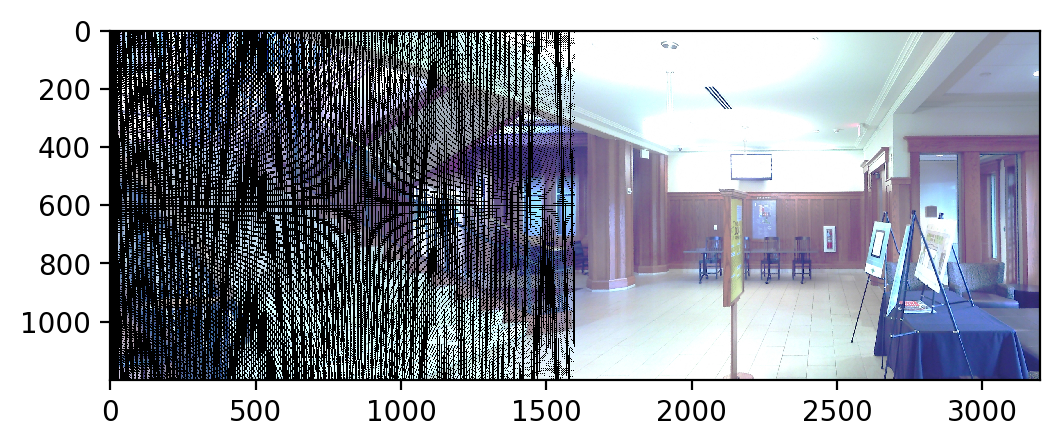

In [36]:
plt.figure(dpi=200)
igs_warp_img = Image.fromarray(igs_warp.astype(np.uint8))
imshow(igs_warp_img)

In [ ]:



# plot images
img_warp = Image.fromarray(igs_warp.astype(np.uint8))
img_merge = Image.fromarray(igs_merge.astype(np.uint8))

# save images
img_warp.save('porto1_warped.png')
img_merge.save('porto_mergeed.png')

In [7]:
def rectify(igs, p1, p2):
    # TODO ...

    return igs_rec

In [9]:
def set_cor_rec():
    # TODO ...

    return c_in, c_ref

In [ ]:

##############
# step 2: rectification
##############

img_rec = Image.open('data/iphone.png').convert('RGB')
igs_rec = np.array(img_rec)

c_in, c_ref = set_cor_rec()

igs_rec = rectify(igs_rec, c_in, c_ref)

img_rec = Image.fromarray(igs_rec.astype(np.uint8))
img_rec.save('iphone_rectified.png')
